## Step - 1: Importing time

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
import re
import string

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

2024-02-26 11:28:45.126442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 11:28:45.126547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 11:28:45.246119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

nlp = spacy.load('en_core_web_sm')

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


## Step - 2: GloVe Installation & Setup

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-02-26 11:29:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 38s  

2024-02-26 11:31:45 (5.19 MB/s) - 'glove.6B.zip' saved [862182613/862182613]



In [ ]:
# Get the GloVe into our directory
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


## Step - 3: Dataset Cleaning Time!

In [ ]:
train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', index_col=0, header=None, names=['entity', 'label', 'text'])
test = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', index_col=0, header=None, names=['entity', 'label', 'text'])

Function Lobby

In [ ]:
def lowercase(data):
    return data['text'].str.lower()

def change_punctuation(data):
    return data['text'].str.replace('`', "'")

def remove_numbers(data):
    return data['text'].replace('[^a-zA-z.,!?/:;\"\'\s]', '', regex=True)

def remove_special_characters(data):
    return data['text'].replace('[^a-zA-Z0-9 ]', '', regex=True)

def custom(data):
    return data['text'].replace('im', 'i am')

def lemmatize(data):
    lemmatized_array = []

    for text in data['text']:
        lemmatized_text = []
        doc = nlp(text)
        for token in doc:
            lemmatized_text.append(token.lemma_)
        lemmatized_array.append(' '.join(lemmatized_text))
    return lemmatized_array

def stop_words(data):
    stop_words_array = []
    for text in data['text']:
        doc = nlp(text)
        filtered_tokens = [token.text for token in doc if not token.is_stop]
        stop_words_array.append(' '.join(filtered_tokens))
    return stop_words_array

def delete_links(data):
    return data['text'].replace(r'http\S+', '', regex=True)

def preprocessing(data):
    df = data.copy()
    df['text'] = lowercase(df)
    df['text'] = custom(df)
    df['text'] = change_punctuation(df)
    df['text'] = lemmatize(df)
    df['text'] = remove_numbers(df)
    df['text'] = delete_links(df)
    df['text'] = remove_special_characters(df)
    return df

In [ ]:
# As seen in dataset, the first entry itself contains many multiple words
train.drop_duplicates(subset=['text'], inplace=True)
train.reset_index(inplace=True)
train['text'] = train['text'].astype('str')
test['text'] = test['text'].astype('str')

In [ ]:
len(train['text'])
len(test['text'])

1000

In [ ]:
# Time to preprocess data, This gonna take long time so get yourself a drink by then...
train = preprocessing(train)
test = preprocessing(test)

Encoding Time!

In [ ]:
le = LabelEncoder()
train['label'] = le.fit_transform(train['label'])
test['label'] = le.transform(test['label'])

X = train['text']
y = train['label']

Now we use the encoded data in X and Y and split them for our model training.

In [ ]:
max_words = 10000
maxlen = 200
emb_dim = 50
training_samples = int(len(X) * 0.8)

text_dataset = tf.data.Dataset.from_tensor_slices(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

Time for vectorization!

In [ ]:
max_features = 20000
embedding_dim = 128

vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=max_words, # Max number of word in the internal dictionnary. We keep the most frequent
        output_mode='int',
        output_sequence_length=maxlen  # Size max of text
        )

vectorize_layer.adapt(text_dataset.batch(64))

In [ ]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8305 words (1695 misses)


One last step before we start building the model...

In [ ]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

## Step - 4: ANN Model!

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Time to cook the model...Use GPU if you have low amount of patient
cl = [tf.keras.callbacks.EarlyStopping(
                  monitor='val_accuracy',
                  restore_best_weights=True,
                  patience=10)]

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=64, callbacks = cl)

Epoch 1/50


I0000 00:00:1708947722.450836      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


869/869 [==============================] - 10s 6ms/step - loss: 1.3216 - accuracy: 0.3780 - val_loss: 1.1977 - val_accuracy: 0.4760
Epoch 2/50
869/869 [==============================] - 5s 6ms/step - loss: 1.2151 - accuracy: 0.4708 - val_loss: 1.1413 - val_accuracy: 0.5164
Epoch 3/50
869/869 [==============================] - 5s 6ms/step - loss: 1.1443 - accuracy: 0.5144 - val_loss: 1.0855 - val_accuracy: 0.5415
Epoch 4/50
869/869 [==============================] - 5s 6ms/step - loss: 1.0778 - accuracy: 0.5469 - val_loss: 1.0362 - val_accuracy: 0.5692
Epoch 5/50
869/869 [==============================] - 5s 6ms/step - loss: 1.0144 - accuracy: 0.5778 - val_loss: 1.0235 - val_accuracy: 0.5746
Epoch 6/50
869/869 [==============================] - 5s 6ms/step - loss: 0.9563 - accuracy: 0.6053 - val_loss: 0.9729 - val_accuracy: 0.6000
Epoch 7/50
869/869 [==============================] - 5s 6ms/step - loss: 0.9038 - accuracy: 0.6308 - val_loss: 0.9515 - val_accuracy: 0.6228
Epoch 8/50
869/8

Some Important Graphs that gives you understanding on your model like wether it cooked properly or screwed up

<Axes: >

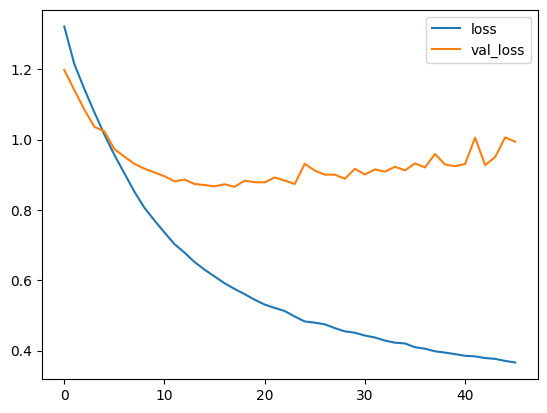

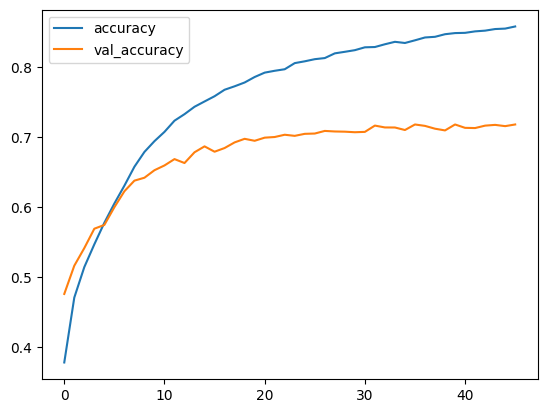

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
predictions = model.predict(test['text'])

32/32 [==============================] - 0s 2ms/step


## Step - 5: Prediction Time

In [ ]:
test['label'] = le.fit_transform(test['label'])

In [ ]:
predicted_labels = []

for predictions_array in predictions:
    predicted_labels.append(np.argmax(predictions_array))

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(predicted_labels, test['label'])

0.91

In [ ]:
print(predicted_labels)

[0, 2, 1, 1, 2, 1, 3, 3, 3, 1, 3, 3, 1, 2, 1, 3, 3, 1, 3, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 3, 3, 1, 3, 1, 2, 3, 2, 3, 2, 3, 2, 2, 2, 3, 2, 1, 1, 1, 2, 3, 1, 1, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 0, 1, 2, 1, 0, 3, 1, 3, 1, 3, 3, 3, 0, 3, 0, 2, 2, 0, 3, 3, 2, 3, 2, 1, 0, 1, 2, 2, 2, 3, 0, 0, 1, 1, 1, 2, 1, 2, 1, 3, 3, 2, 0, 2, 3, 1, 2, 2, 2, 1, 2, 1, 2, 2, 3, 3, 2, 1, 1, 3, 1, 2, 1, 3, 2, 1, 2, 0, 3, 2, 0, 3, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 3, 3, 2, 1, 3, 3, 1, 2, 3, 2, 0, 2, 1, 2, 3, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 3, 3, 3, 2, 2, 3, 0, 2, 2, 2, 3, 2, 1, 1, 2, 3, 3, 0, 0, 2, 3, 3, 2, 0, 2, 1, 1, 1, 1, 3, 2, 2, 3, 3, 3, 3, 1, 3, 3, 0, 2, 0, 1, 0, 0, 0, 1, 3, 3, 1, 0, 1, 3, 3, 1, 2, 0, 3, 3, 1, 3, 0, 2, 0, 0, 1, 2, 2, 3, 1, 0, 0, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 3, 2, 2, 3, 1, 2, 3, 2, 1, 2, 2, 1, 3, 3, 0, 1, 2, 0, 3, 2, 0, 1, 2, 1, 3, 3, 1, 1, 1, 3, 1, 2, 3, 2, 2, 1, 3, 1, 3, 1, 0, 2, 2, 3, 1, 2, 1, 0, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 1, 3, 1, 0, 2, 3, 1, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 3, 1, 1, 

In [ ]:
print(test['label'])

3364    0
352     2
8312    1
4371    1
4433    2
       ..
4891    0
4359    0
2652    3
8069    3
6960    2
Name: label, Length: 1000, dtype: int64
